## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_lines = list(map(lambda s: s.lower(), text))

text = (''.join(text)).lower()
print(len(text))
out = text

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

100225
OK!


### Data loading: "Евгений Онегин"


In [4]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

import codecs

with codecs.open("onegin.txt", "r", "utf_8_sig") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

len(text)

7088

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

# out = (''.join(text)).lower()

Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(out))

len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here
idx_to_token = list(tokens)

# dict <char>:<index>
# Your great code here
token_to_idx = {}
for i in range(len(tokens)):
    token_to_idx[tokens[i]] = i

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [8]:
# Your code here

import numpy as np

def to_matrix(lines, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad

    for i in range(len(lines)):
        line_ix = [token_to_idx[c] for c in lines[i]]
        lines_ix[i, :len(line_ix)] = line_ix

    if not batch_first:
        lines_ix = np.transpose(lines_ix)

    return lines_ix

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [9]:
text_lines[:2]

print(text_lines[:2])
print(to_matrix(text_lines[:2]))

['  from fairest creatures we desire increase,\n', "  that thereby beauty's rose might never die,\n"]
[[ 1  1 17 29 26 24  1 17 12 20 29 16 30 31  1 14 29 16 12 31 32 29 16 30
   1 34 16  1 15 16 30 20 29 16  1 20 25 14 29 16 12 30 16  6  0  1]
 [ 1  1 31 19 12 31  1 31 19 16 29 16 13 36  1 13 16 12 32 31 36  3 30  1
  29 26 30 16  1 24 20 18 19 31  1 25 16 33 16 29  1 15 20 16  6  0]]


In [10]:
STATE_LENGTH = 128
LINE_MAX_LENGTH = 64
TOKENS_LENGTH = len(tokens)
BATCH_LENGTH = 32


In [11]:
import torch
import torch.nn as nn

class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=TOKENS_LENGTH, embedding_size=LINE_MAX_LENGTH, rnn_num_units=STATE_LENGTH):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)
        h_next = torch.tanh(h_next)

        assert h_next.size() == h_prev.size()

        logits = self.rnn_to_logits(h_next)

        return h_next, nn.functional.log_softmax(logits, -1)
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.num_units, requires_grad=True)


In [12]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

In [13]:
def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.init_hidden(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1):
        hid_state, logp_next = char_rnn(x_t, hid_state)
        logprobs.append(logp_next)

    return torch.stack(logprobs, dim=1)


In [14]:
batch_ix = to_matrix(text_lines[:5])
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0

In [15]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
from random import sample

char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
loss_history = []


i: 999 Loss: 0.9617



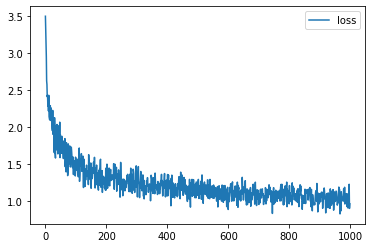

In [16]:

for i in range(1000):
    batch_ix = to_matrix(sample(text_lines, BATCH_LENGTH), max_len=LINE_MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = rnn_loop(char_rnn, batch_ix)
    prediction_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(prediction_logp.contiguous().view(-1, TOKENS_LENGTH), actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_item = loss.item()
    loss_history.append(loss_item)
    if (i+1)%10 == 0:
        clear_output(True)
        print('\ni: {} Loss: {:.4f}\n'.format(i, loss_item))

        plt.plot(loss_history, label='loss')
        plt.legend()
        plt.show()


In [17]:
# Your plot code here

In [18]:
def generate_sample(rnn, seed_phrase=' ', max_length=LINE_MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[c] for c in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = rnn.init_hidden(batch_size = 1)
    
    #feed the seed phrase, if any
    for i in range(1, len(seed_phrase)):
        # print(x_sequence[:, -1].shape, hid_state.shape)
        hid_state, out = rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(LINE_MAX_LENGTH - len(seed_phrase)):
        # print(x_sequence.shape, x_sequence, hid_state.shape)
        hid_state, out = rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = nn.functional.softmax(out / temperature, dim=-1).data.numpy()[0]
        
        # sample next token and push it back into x_sequence
        # print(p_next.shape, TOKENS_LENGTH)
        next_ix = np.random.choice(TOKENS_LENGTH, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        # print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [19]:
# An example of generated text.
# print(generate_text(length=500, temperature=0.2))

In [20]:
def generate_poem(model, temperature=1.0, lines_count=15):
    poem_lines = []
    for i in range(lines_count):
        poem_lines.append(generate_sample(model, temperature=temperature).strip())

    poem = '\n'.join(poem_lines)
    print(poem)
    return poem



In [21]:
generate_poem(char_rnn, 0.9)


the am forn,
live now reppaint:
but wild sidie then links oo mess all-junderes a is the fory d
whin i no sost chines day self reed i then bespeach see,
the haif with and thousef goon'er you the lo deion's fort wore
and new is theefons lose tile,--
for hearks of dight but wich shich rencune cord,
thy with all, a time vine's exvost in these for healt aw in
! to my arten thee, bor cind?
hat  in's lom net owing to thoo long the hammen inded decexing
will orns'st, and lift the oot his sume see parged shell'ster
but if should your you pieth share,
the doth swarts that sto breep,
to sume you a lust thens the ray dorbelf borthe, but wind,
then my ored hom, i love reess land mure my loves, buther dete


"the am forn,\nlive now reppaint:\nbut wild sidie then links oo mess all-junderes a is the fory d\nwhin i no sost chines day self reed i then bespeach see,\nthe haif with and thousef goon'er you the lo deion's fort wore\nand new is theefons lose tile,--\nfor hearks of dight but wich shich rencune cord,\nthy with all, a time vine's exvost in these for healt aw in\n! to my arten thee, bor cind?\nhat  in's lom net owing to thoo long the hammen inded decexing\nwill orns'st, and lift the oot his sume see parged shell'ster\nbut if should your you pieth share,\nthe doth swarts that sto breep,\nto sume you a lust thens the ray dorbelf borthe, but wind,\nthen my ored hom, i love reess land mure my loves, buther dete"

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [22]:
# Your beautiful code here

class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=LINE_MAX_LENGTH, rnn_num_units=STATE_LENGTH):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        x_emb = self.embedding(x)
        h_seq, _ = self.rnn(x_emb)
        next_logits = self.hid_to_logits(h_seq)
        next_logp = nn.functional.log_softmax(next_logits, dim=-1)
        return next_logp


In [23]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.NLLLoss()
loss_history = []


i: 999 Loss: 1.1333



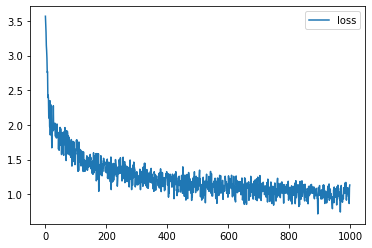

In [24]:
model.train()

for i in range(1000):
    batch_ix = to_matrix(sample(text_lines, BATCH_LENGTH), max_len=LINE_MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)
    prediction_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    loss = criterion(prediction_logp.contiguous().view(-1, TOKENS_LENGTH), actual_next_tokens.contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()

    loss_item = loss.item()
    loss_history.append(loss_item)
    if (i+1)%10 == 0:
        clear_output(True)
        print('\ni: {} Loss: {:.4f}\n'.format(i, loss_item))

        plt.plot(loss_history, label='loss')
        plt.legend()
        plt.show()

In [25]:
def generate_sample_torch(rnn, seed_phrase=' ', max_length=LINE_MAX_LENGTH, temperature=1.0):
    x_sequence = [token_to_idx[c] for c in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    for i in range(1, len(seed_phrase)):
        out = rnn(x_sequence)
    
    for _ in range(LINE_MAX_LENGTH - len(seed_phrase)):
        out = rnn(x_sequence)
        p_next = nn.functional.softmax(out / temperature, dim=-1).data.numpy()[0][-1]
        
        next_ix = np.random.choice(TOKENS_LENGTH, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [26]:
def generate_poem_torch(model, temperature=1.0, lines_count=15):
    poem_lines = []
    for i in range(lines_count):
        poem_lines.append(generate_sample_torch(model, temperature=temperature).strip())

    poem = '\n'.join(poem_lines)
    print(poem)
    return poem

In [27]:
model.eval()

generate_poem_torch(model)

for'd the chan am row strease jreat,
fale the no urittith, mine stroldss threispor?
of i plenciot it mast yevirsing,
is netger chaver of then tuee' thy som rays
and thing it thous other saakel hight.
and shear, in thith had jutsant more mowerings thebe
conreiss to and formorned
is if flengshing resprend,
in the will in acqearpends, the singaght,
yablong one as fainty ith gard,
cxv
and to mast i as gy foin,
that boruth:
cblanwos thine stok deat rovers?
and phikent tuss thing encom benot love;


"for'd the chan am row strease jreat,\nfale the no urittith, mine stroldss threispor?\nof i plenciot it mast yevirsing,\nis netger chaver of then tuee' thy som rays\nand thing it thous other saakel hight.\nand shear, in thith had jutsant more mowerings thebe\nconreiss to and formorned\nis if flengshing resprend,\nin the will in acqearpends, the singaght,\nyablong one as fainty ith gard,\ncxv\nand to mast i as gy foin,\nthat boruth:\ncblanwos thine stok deat rovers?\nand phikent tuss thing encom benot love;"

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [28]:
# Text generation with different temperature values here

for temp in [0.1, 0.2, 0.5, 1.0, 2.0]:
    print('TEMPERATURE=' + str(temp))
    generate_poem_torch(model)

TEMPERATURE=0.1
no not what with than hoking mosh, bless,
ey hep, or thee thou, art withures me aiw so refvenst ow thow
so reswase of withine, tho gride of expned't,
ir netty fleanes mes. you theirllorsing;
i nave whowery then doth mule haid tit;
and with was, to greccksmod, and am  thoun,
thy hown steecer, a conce thele dear trie:
'in thee vinss the spenthing blow'
men efine ong othon beth'st income?
wher bearn thast hath stromitone:
o! an  for thou tounqurt, all songee,
male is thou accospee is to notwith,
and 'vlile bleac wer' the whath deross somey,
ince the beat stand my frow, fortare on my hany:
whear prode than trus thon mus neich hickon wiad,
TEMPERATURE=0.2
which thy whinc out tire strime im farce
for stilber enceing slov'd on chous, astan
but me with live, tum to the deest,
but thee alone, of make'd and my slets' thee;
and soin-stright it the lad'st of ny,-
ary fi love time,-:
'por whenatuse thy beark, nool the thou waare:
aray suppriont'st man allen hith shall.
fourst aje yo

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [29]:
# Saving and loading code here

MODEL_STATE_PATH = 'trained_model'
torch.save(model.state_dict(), MODEL_STATE_PATH)

new_model = CharRNNLoop()
new_model.load_state_dict(torch.load(MODEL_STATE_PATH))
new_model.eval()

generate_poem_torch(new_model)

save theal as acfourusiges eyer;
wids flie rath soms so are im have tide anning
and of this tha caillon dews, and ere thees is-idnfv?
uline worght those shitk, no fainter forliom,
and thou the blidgs in to lief in thy.
ver, not thy pots startit with cive moll.
that houbgut fouln of my in wost be minift;?
for weeds il make kis spall that lie,
pankuse welf graicys mote lapore seal'd
thut whenteous barse for not heart to loves,
hagk knows the main'd on of with neads,
he nery made this treemoned;
liching cove amn ip me m! lxvees did,
mo!t nathight thought doud my stande say:
thou doursem there-doth thigh a chatk, not deey,


"save theal as acfourusiges eyer;\nwids flie rath soms so are im have tide anning\nand of this tha caillon dews, and ere thees is-idnfv?\nuline worght those shitk, no fainter forliom,\nand thou the blidgs in to lief in thy.\nver, not thy pots startit with cive moll.\nthat houbgut fouln of my in wost be minift;?\nfor weeds il make kis spall that lie,\npankuse welf graicys mote lapore seal'd\nthut whenteous barse for not heart to loves,\nhagk knows the main'd on of with neads,\nhe nery made this treemoned;\nliching cove amn ip me m! lxvees did,\nmo!t nathight thought doud my stande say:\nthou doursem there-doth thigh a chatk, not deey,"

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)